### Data preprocessing for Deep Learning Model

In [629]:
#載入套件
import numpy
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import d2l
from mxnet import autograd, gluon, np, npx ,nd ,init
from mxnet.gluon import nn
npx.set_np()

In [3]:
import mxnet as mx

In [4]:
#載入套件 並讀入資料集
import pickle

with open('msd_full.pickle','rb') as f:
    myobj = pickle.load(f)

In [5]:
myobj

{'X_train': array([[  53.39967,   56.67781,   55.63508, ...,    1.3159 ,    2.37448,
            1.85999],
        [  42.83464,  -33.90478,   38.97704, ...,    9.72827, -175.51446,
          -15.8389 ],
        [  49.88591,   23.30563,   54.79012, ...,    1.94152,  101.27241,
            8.99355],
        ...,
        [  48.69997,   72.78532,   27.79159, ...,   -1.70515,   39.9382 ,
            4.83517],
        [  49.45505,   56.51035,   15.80259, ...,  -10.0645 ,   42.57409,
          -12.3541 ],
        [  40.31555,  -29.88336,    8.87396, ...,    5.81771,  -50.36502,
           -8.57407]]),
 'Y_train': array([1996., 2001., 2003., ..., 1991., 2005., 1996.]),
 'X_test': array([[ 38.51784,  55.38723,  10.31652, ...,   6.66624, -73.75585,
           9.47857],
        [ 44.7309 ,  46.25776,   8.55636, ...,   4.5564 ,  53.49956,
           5.39116],
        [ 43.08912,  45.70197,  17.18467, ..., -13.64909,  -7.42137,
          -4.97266],
        ...,
        [ 39.12578, -70.57977,  38.04

In [6]:
print(myobj['X_train'].shape)
print(myobj['Y_train'].shape)
print(myobj['X_test'].shape)
print(myobj['Y_test'].shape)

(463715, 90)
(463715,)
(51630, 90)
(51630,)


In [7]:
X_train=myobj['X_train']
Y_train=myobj['Y_train']
X_test=myobj['X_test']
Y_test=myobj['Y_test']

In [8]:
type(X_train)

numpy.ndarray

In [9]:
#載入sklearn的StandardScaler 用來標準化，並將train_x和test_x 都用train_x資料來做標準化，再跑regression
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_standard = scaler.transform(X_train)
X_test_standard = scaler.transform(X_test)

In [10]:
#轉換mxnet資料型態
X_train_standard=np.array(X_train_standard,dtype=np.float32)
Y_train=np.array(Y_train,dtype=np.float32)
X_test_standard=np.array(X_test_standard,dtype=np.float32)
Y_test=np.array(Y_test,dtype=np.float32)

In [11]:
type(X_train_standard)

mxnet.numpy.ndarray

In [12]:
size=int(len(X_train_standard)*0.9)
size

417343

In [13]:
#reserve the last 10% of the training dataset as the validation set, and the remaining 90% as the subtraining set
subtrain_x=X_train_standard[:size]
validation_x=X_train_standard[size:]

In [14]:
subtrain_y=Y_train[:size]
validation_y=Y_train[size:]

In [15]:
#取前10000筆 subtrain
subtrain_x_10000=subtrain_x[:10000]
subtrain_y_10000=subtrain_y[:10000]

In [16]:
subtrain_x_10000.shape

(10000, 90)

In [17]:
subtrain_y_10000.shape

(10000,)

In [18]:
type(subtrain_x_10000)

mxnet.numpy.ndarray

In [19]:
type(subtrain_y_10000)

mxnet.numpy.ndarray

In [20]:
#定義出RMSE的函數
def RMSE(y, y_pred):
    mse = np.mean((y - y_pred)**2) 
    return  np.sqrt(mse)

## Q1

### Case OLS

In [21]:
#載入sklearn的OLS regression
from sklearn.linear_model import LinearRegression
reg1 = LinearRegression().fit(subtrain_x_10000.asnumpy(),subtrain_y_10000.asnumpy())
ypred1 = reg1.predict(X_test_standard.asnumpy())

In [22]:
ypred1

array([1992.5251, 1998.2167, 2003.9835, ..., 1994.5137, 1996.6868,
       1998.5167], dtype=float32)

In [23]:
Y_test

array([1998., 1988., 2005., ..., 2003., 2000., 2000.])

In [24]:
#印出RMSE
RMSE1=RMSE(Y_test,np.array(ypred1))
print(RMSE1)

9.550725


### MLP_0_dm

In [25]:
#算出train_y的平均值
train_y_mean= np.mean(Y_train,axis=0)
train_y_mean

array(1998.3861)

In [26]:
#將y給demean 並用其來跑regression 並會將Y_test也減去 train_y的平均值
train_y_demean = Y_train - train_y_mean
test_y_demean = Y_test - train_y_mean

In [27]:
#將y給demean 
subtrain_y_demean = subtrain_y-train_y_mean
validation_y_demean = validation_y-train_y_mean
subtrain_y_10000_demean = subtrain_y_10000-train_y_mean

In [28]:
type(subtrain_y_10000_demean)

mxnet.numpy.ndarray

In [29]:
type(validation_y_demean)

mxnet.numpy.ndarray

In [30]:
data_ctx = mx.cpu()
model_ctx = mx.cpu()

In [31]:
batch_size = 10
train_data = gluon.data.DataLoader(gluon.data.ArrayDataset(subtrain_x_10000, subtrain_y_10000_demean),
                                      batch_size=batch_size, shuffle=True)

In [32]:
net = nn.Sequential()
net.add(nn.Dense(1))

In [33]:
#net = gluon.nn.Dense(1, in_units=subtrain_x_10000.shape[1])

In [34]:
net.initialize(init.Normal(sigma=0.01))

In [35]:
net.collect_params()

sequential0_ (
  Parameter dense0_weight (shape=(1, -1), dtype=float32)
  Parameter dense0_bias (shape=(1,), dtype=float32)
)

In [36]:
square_loss = gluon.loss.L2Loss()

In [37]:
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.0001})

In [38]:
num_examples = 10000

In [39]:
epochs = 3000
loss_sequence = []
num_batches = num_examples / batch_size
validation_RMSE=[]

In [40]:
for e in range(epochs):
    cumulative_loss = 0
    # inner loop
    for i, (data, label) in enumerate(train_data):
        data = data.as_in_context(model_ctx)
        label = label.as_in_context(model_ctx)
        with autograd.record():
            output = net(data)
            loss = square_loss(output, label)
        loss.backward()
        trainer.step(batch_size)
        cumulative_loss += np.mean(loss)
        
    pre=net(validation_x)
    pre=pre.reshape(-1,)
    v_RMSE=RMSE(validation_y_demean,pre)
    validation_RMSE.append(v_RMSE)
    print("Epoch %s, loss: %s,  validation RMSE: %s" % (e+1, cumulative_loss / num_examples,v_RMSE))
    loss_sequence.append(cumulative_loss)
    
    if len(validation_RMSE)>50:
        if ( float(validation_RMSE[-50]) - float(validation_RMSE[-1])) <=0.001:
            break #early stop

Epoch 1, loss: 5.8319306,  validation RMSE: 10.635646
Epoch 2, loss: 5.5991273,  validation RMSE: 10.459597
Epoch 3, loss: 5.4503255,  validation RMSE: 10.336612
Epoch 4, loss: 5.342558,  validation RMSE: 10.244406
Epoch 5, loss: 5.259569,  validation RMSE: 10.172737
Epoch 6, loss: 5.1931443,  validation RMSE: 10.1137905
Epoch 7, loss: 5.137674,  validation RMSE: 10.064521
Epoch 8, loss: 5.0907583,  validation RMSE: 10.023836
Epoch 9, loss: 5.050577,  validation RMSE: 9.987762
Epoch 10, loss: 5.0155377,  validation RMSE: 9.956691
Epoch 11, loss: 4.984549,  validation RMSE: 9.928909
Epoch 12, loss: 4.957027,  validation RMSE: 9.904368
Epoch 13, loss: 4.9322424,  validation RMSE: 9.882248
Epoch 14, loss: 4.9100585,  validation RMSE: 9.862255
Epoch 15, loss: 4.8898516,  validation RMSE: 9.843902
Epoch 16, loss: 4.8713326,  validation RMSE: 9.827572
Epoch 17, loss: 4.854396,  validation RMSE: 9.811978
Epoch 18, loss: 4.8388276,  validation RMSE: 9.798949
Epoch 19, loss: 4.8244205,  validat

Epoch 154, loss: 4.5874596,  validation RMSE: 9.57223
Epoch 155, loss: 4.5873384,  validation RMSE: 9.571873
Epoch 156, loss: 4.587265,  validation RMSE: 9.571625
Epoch 157, loss: 4.587235,  validation RMSE: 9.57209
Epoch 158, loss: 4.5868115,  validation RMSE: 9.573352
Epoch 159, loss: 4.5871487,  validation RMSE: 9.572937
Epoch 160, loss: 4.5870314,  validation RMSE: 9.572575
Epoch 161, loss: 4.5869193,  validation RMSE: 9.572675
Epoch 162, loss: 4.586725,  validation RMSE: 9.571701
Epoch 163, loss: 4.5866747,  validation RMSE: 9.572713
Epoch 164, loss: 4.5867248,  validation RMSE: 9.572405
Epoch 165, loss: 4.586576,  validation RMSE: 9.572691
Epoch 166, loss: 4.586483,  validation RMSE: 9.571532
Epoch 167, loss: 4.5865235,  validation RMSE: 9.571951
Epoch 168, loss: 4.5863748,  validation RMSE: 9.571764
Epoch 169, loss: 4.586459,  validation RMSE: 9.571915
Epoch 170, loss: 4.5864377,  validation RMSE: 9.571674
Epoch 171, loss: 4.5863485,  validation RMSE: 9.571593
Epoch 172, loss: 4

In [41]:
loss_sequence

[array(58319.305),
 array(55991.273),
 array(54503.254),
 array(53425.58),
 array(52595.69),
 array(51931.44),
 array(51376.74),
 array(50907.582),
 array(50505.77),
 array(50155.38),
 array(49845.49),
 array(49570.27),
 array(49322.426),
 array(49100.586),
 array(48898.516),
 array(48713.324),
 array(48543.96),
 array(48388.277),
 array(48244.203),
 array(48112.23),
 array(47989.383),
 array(47874.605),
 array(47767.695),
 array(47666.305),
 array(47572.605),
 array(47486.53),
 array(47405.19),
 array(47328.88),
 array(47256.22),
 array(47188.582),
 array(47123.125),
 array(47064.613),
 array(47008.906),
 array(46954.81),
 array(46904.25),
 array(46856.62),
 array(46812.934),
 array(46769.617),
 array(46729.73),
 array(46692.188),
 array(46654.812),
 array(46621.766),
 array(46589.86),
 array(46556.832),
 array(46527.113),
 array(46501.613),
 array(46474.645),
 array(46450.86),
 array(46427.297),
 array(46404.164),
 array(46382.324),
 array(46361.195),
 array(46342.91),
 array(46323.3

Text(0, 0.5, 'average loss')

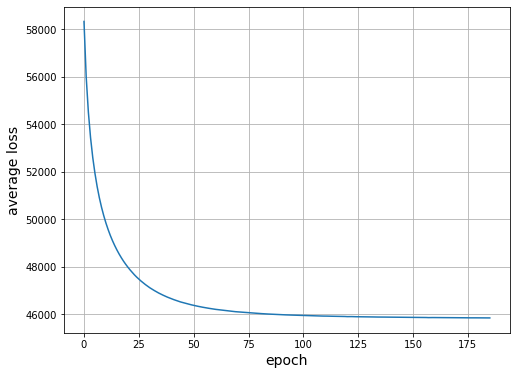

In [42]:
# plot the convergence of the estimated loss function
plt.figure(num=None,figsize=(8, 6))
plt.plot(loss_sequence,label="loss")
# Adding some bells and whistles to the plot
plt.grid(True, which="both")
plt.xlabel('epoch',fontsize=14)
plt.ylabel('average loss',fontsize=14)

Text(0, 0.5, 'validation RMSE')

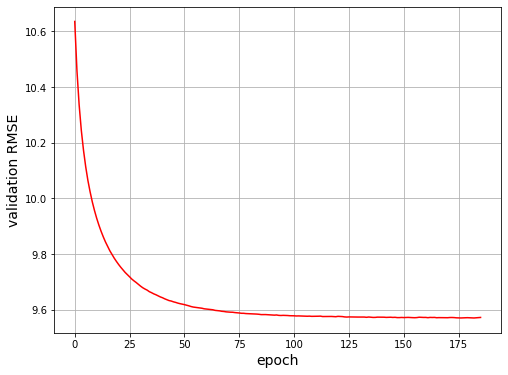

In [43]:
# plot the convergence of the validation RMSE
plt.figure(num=None,figsize=(8, 6))
plt.plot(validation_RMSE,c="red",label="validation RMSE")
# Adding some bells and whistles to the plot
plt.grid(True, which="both")
plt.xlabel('epoch',fontsize=14)
plt.ylabel('validation RMSE',fontsize=14)

In [44]:
params = net.collect_params() # this returns a ParameterDict

print('The type of "params" is a ',type(params))

# A ParameterDict is a dictionary of Parameter class objects
# therefore, here is how we can read off the parameters from it.

for param in params.values():
    print(param.name,param.data())

The type of "params" is a  <class 'mxnet.gluon.parameter.ParameterDict'>
dense0_weight [[ 4.850594   -2.8671236  -1.4075136   0.00540132 -0.36790177 -2.9322195
   0.09394313 -0.9050711  -0.6772961   0.11501078 -0.31197333 -0.2854725
   0.8918524   0.29775017 -0.7279748   0.6934636   0.2099742   1.01035
   0.5476642   0.8383359   0.21209957  0.12135356  1.4632825   0.44640276
  -0.2947721   0.1333835   1.0514582   0.12012462  0.20019737 -0.10368352
  -0.3374506  -0.26342586 -0.35661408 -0.02962561  0.03944996 -0.6030887
   0.01275518  0.20696364  0.3421922  -0.17991193 -0.34384006 -0.20445566
   0.01076313  0.08461602 -0.22557841  0.22893818 -0.07466001 -0.5214056
  -0.10126784  0.46051025  0.29764435  0.05208644  0.06438173  0.18599986
   0.17029755  0.06151357 -0.5574119   0.42075488 -0.11333305  0.09249829
  -0.29415864  0.13142295 -0.29766712  0.25515234 -0.6319055   0.09050934
  -0.03275031 -0.03853124 -0.38254425 -0.2281652  -0.670923   -0.02716398
   0.16738348  0.43621984  0.153

In [45]:
net

Sequential(
  (0): Dense(90 -> 1, linear)
)

In [46]:
pre2=net(X_test_standard)

In [47]:
pre2=pre2.reshape(-1,)

In [48]:
pre2.shape

(51630,)

In [49]:
Y_test.shape

(51630,)

In [50]:
#印出RMSE
RMSE2=RMSE(test_y_demean,pre2)
print(RMSE2)

9.549119


### MLP_1_dm	

In [51]:
net = nn.Sequential()
net.add(nn.Dense(45, activation='relu'),
        nn.Dense(1))
net.initialize(init.Normal(sigma=0.01))

In [52]:
net.collect_params()

sequential1_ (
  Parameter dense1_weight (shape=(45, -1), dtype=float32)
  Parameter dense1_bias (shape=(45,), dtype=float32)
  Parameter dense2_weight (shape=(1, -1), dtype=float32)
  Parameter dense2_bias (shape=(1,), dtype=float32)
)

In [53]:
square_loss = gluon.loss.L2Loss()
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.0001})
num_examples = 10000

In [54]:
epochs = 3000
loss_sequence = []
num_batches = num_examples / batch_size
validation_RMSE=[]

In [55]:
for e in range(epochs):
    cumulative_loss = 0
    # inner loop
    for i, (data, label) in enumerate(train_data):
        data = data.as_in_context(model_ctx)
        label = label.as_in_context(model_ctx)
        with autograd.record():
            output = net(data)
            loss = square_loss(output, label)
        loss.backward()
        trainer.step(batch_size)
        cumulative_loss += np.mean(loss)
        
    pre=net(validation_x)
    pre=pre.reshape(-1,)
    v_RMSE=RMSE(validation_y_demean,pre)
    validation_RMSE.append(v_RMSE)
    print("Epoch %s, loss: %s,  validation RMSE: %s" % (e+1, cumulative_loss / num_examples,v_RMSE))
    loss_sequence.append(cumulative_loss)
    
    if len(validation_RMSE)>50:
        if ( float(validation_RMSE[-50]) - float(validation_RMSE[-1])) <=0.001:
            break #early stop

Epoch 1, loss: 5.982077,  validation RMSE: 10.920558
Epoch 2, loss: 5.980888,  validation RMSE: 10.919212
Epoch 3, loss: 5.9790244,  validation RMSE: 10.916887
Epoch 4, loss: 5.9756155,  validation RMSE: 10.912534
Epoch 5, loss: 5.969158,  validation RMSE: 10.904177
Epoch 6, loss: 5.956708,  validation RMSE: 10.888115
Epoch 7, loss: 5.932967,  validation RMSE: 10.857829
Epoch 8, loss: 5.889707,  validation RMSE: 10.804256
Epoch 9, loss: 5.8170037,  validation RMSE: 10.718113
Epoch 10, loss: 5.708539,  validation RMSE: 10.596571
Epoch 11, loss: 5.567174,  validation RMSE: 10.445756
Epoch 12, loss: 5.400472,  validation RMSE: 10.271833
Epoch 13, loss: 5.2176614,  validation RMSE: 10.08737
Epoch 14, loss: 5.034131,  validation RMSE: 9.913194
Epoch 15, loss: 4.868729,  validation RMSE: 9.75867
Epoch 16, loss: 4.7293806,  validation RMSE: 9.638023
Epoch 17, loss: 4.6184826,  validation RMSE: 9.542246
Epoch 18, loss: 4.530657,  validation RMSE: 9.471058
Epoch 19, loss: 4.4629216,  validation

Text(0, 0.5, 'average loss')

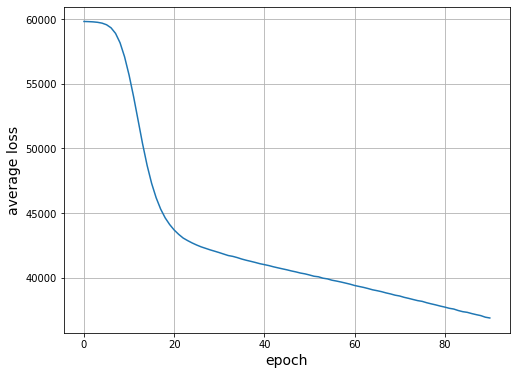

In [56]:
# plot the convergence of the estimated loss function
plt.figure(num=None,figsize=(8, 6))
plt.plot(loss_sequence,label="loss")
# Adding some bells and whistles to the plot
plt.grid(True, which="both")
plt.xlabel('epoch',fontsize=14)
plt.ylabel('average loss',fontsize=14)

Text(0, 0.5, 'validation RMSE')

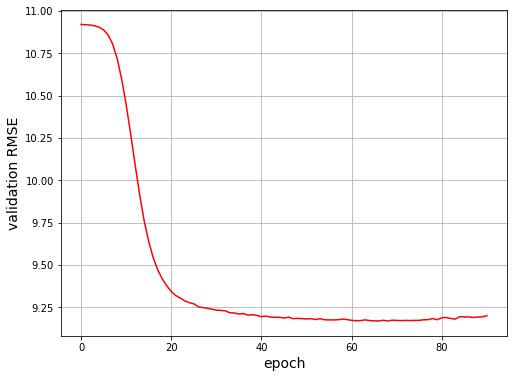

In [57]:
# plot the convergence of the validation RMSE
plt.figure(num=None,figsize=(8, 6))
plt.plot(validation_RMSE,c="red",label="validation RMSE")
# Adding some bells and whistles to the plot
plt.grid(True, which="both")
plt.xlabel('epoch',fontsize=14)
plt.ylabel('validation RMSE',fontsize=14)

In [58]:
net

Sequential(
  (0): Dense(90 -> 45, Activation(relu))
  (1): Dense(45 -> 1, linear)
)

In [59]:
pre3=net(X_test_standard)
pre3=pre3.reshape(-1,)

In [60]:
#印出RMSE
RMSE3=RMSE(test_y_demean,pre3)
print(RMSE3)

9.242959


### MLP_2_dm

In [61]:
net = nn.Sequential()
net.add(nn.Dense(45, activation='relu'),nn.Dense(45, activation='relu'),
        nn.Dense(1))
net.initialize(init.Normal(sigma=0.01))

In [62]:
net.collect_params()

sequential2_ (
  Parameter dense3_weight (shape=(45, -1), dtype=float32)
  Parameter dense3_bias (shape=(45,), dtype=float32)
  Parameter dense4_weight (shape=(45, -1), dtype=float32)
  Parameter dense4_bias (shape=(45,), dtype=float32)
  Parameter dense5_weight (shape=(1, -1), dtype=float32)
  Parameter dense5_bias (shape=(1,), dtype=float32)
)

In [63]:
square_loss = gluon.loss.L2Loss()
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.0001})
num_examples = 10000

In [64]:
epochs = 3000
loss_sequence = []
num_batches = num_examples / batch_size
validation_RMSE=[]

In [65]:
for e in range(epochs):
    cumulative_loss = 0
    # inner loop
    for i, (data, label) in enumerate(train_data):
        data = data.as_in_context(model_ctx)
        label = label.as_in_context(model_ctx)
        with autograd.record():
            output = net(data)
            loss = square_loss(output, label)
        loss.backward()
        trainer.step(batch_size)
        cumulative_loss += np.mean(loss)
        
    pre=net(validation_x)
    pre=pre.reshape(-1,)
    v_RMSE=RMSE(validation_y_demean,pre)
    validation_RMSE.append(v_RMSE)
    print("Epoch %s, loss: %s,  validation RMSE: %s" % (e+1, cumulative_loss / num_examples,v_RMSE))
    loss_sequence.append(cumulative_loss)
    
    if len(validation_RMSE)>50:
        if ( float(validation_RMSE[-20]) - float(validation_RMSE[-1])) <=0.001:
            break #early stop

Epoch 1, loss: 5.982506,  validation RMSE: 10.921444
Epoch 2, loss: 5.9824915,  validation RMSE: 10.921435
Epoch 3, loss: 5.9824924,  validation RMSE: 10.921427
Epoch 4, loss: 5.9824753,  validation RMSE: 10.921418
Epoch 5, loss: 5.9824715,  validation RMSE: 10.92141
Epoch 6, loss: 5.9824624,  validation RMSE: 10.9214
Epoch 7, loss: 5.982454,  validation RMSE: 10.9213915
Epoch 8, loss: 5.9824376,  validation RMSE: 10.921384
Epoch 9, loss: 5.982429,  validation RMSE: 10.921375
Epoch 10, loss: 5.982422,  validation RMSE: 10.921367
Epoch 11, loss: 5.9824142,  validation RMSE: 10.921357
Epoch 12, loss: 5.982404,  validation RMSE: 10.921347
Epoch 13, loss: 5.982392,  validation RMSE: 10.921336
Epoch 14, loss: 5.982373,  validation RMSE: 10.921323
Epoch 15, loss: 5.982366,  validation RMSE: 10.921309
Epoch 16, loss: 5.9823513,  validation RMSE: 10.921295
Epoch 17, loss: 5.9823246,  validation RMSE: 10.921278
Epoch 18, loss: 5.982307,  validation RMSE: 10.92126
Epoch 19, loss: 5.9822927,  val

Text(0, 0.5, 'average loss')

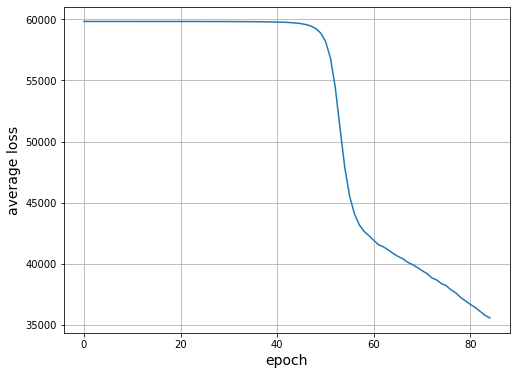

In [66]:
# plot the convergence of the estimated loss function
plt.figure(num=None,figsize=(8, 6))
plt.plot(loss_sequence,label="loss")
# Adding some bells and whistles to the plot
plt.grid(True, which="both")
plt.xlabel('epoch',fontsize=14)
plt.ylabel('average loss',fontsize=14)

Text(0, 0.5, 'validation RMSE')

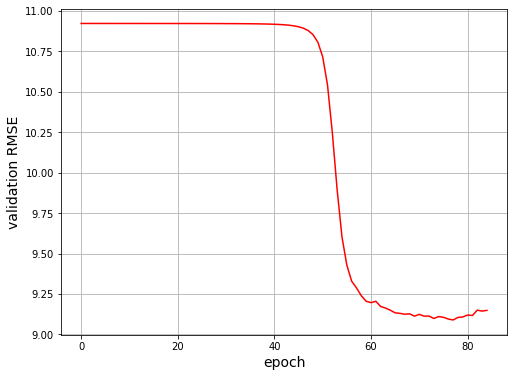

In [67]:
# plot the convergence of the validation RMSE
plt.figure(num=None,figsize=(8, 6))
plt.plot(validation_RMSE,c="red",label="validation RMSE")
# Adding some bells and whistles to the plot
plt.grid(True, which="both")
plt.xlabel('epoch',fontsize=14)
plt.ylabel('validation RMSE',fontsize=14)

In [68]:
net

Sequential(
  (0): Dense(90 -> 45, Activation(relu))
  (1): Dense(45 -> 45, Activation(relu))
  (2): Dense(45 -> 1, linear)
)

In [69]:
pre4=net(X_test_standard)
pre4=pre4.reshape(-1,)

In [70]:
#印出RMSE
RMSE4=RMSE(test_y_demean,pre4)
print(RMSE4)

9.216016


### MLP_2_dm_L2

In [71]:
net = nn.Sequential()
net.add(nn.Dense(45, activation='relu'),nn.Dense(45, activation='relu'),
        nn.Dense(1))
net.initialize(init.Normal(sigma=0.01))

In [72]:
net.collect_params()

sequential3_ (
  Parameter dense6_weight (shape=(45, -1), dtype=float32)
  Parameter dense6_bias (shape=(45,), dtype=float32)
  Parameter dense7_weight (shape=(45, -1), dtype=float32)
  Parameter dense7_bias (shape=(45,), dtype=float32)
  Parameter dense8_weight (shape=(1, -1), dtype=float32)
  Parameter dense8_bias (shape=(1,), dtype=float32)
)

In [73]:
wd=0.03

In [74]:
square_loss = gluon.loss.L2Loss()
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.0001,'wd': wd})
num_examples = 10000

In [75]:
# The bias parameter has not decayed. Bias names generally end with "bias"
net.collect_params('.*bias').setattr('wd_mult', 0)

In [76]:
epochs = 3000
loss_sequence = []
num_batches = num_examples / batch_size
validation_RMSE=[]

In [77]:
for e in range(epochs):
    cumulative_loss = 0
    v_RMSE = 0
    # inner loop
    for i, (data, label) in enumerate(train_data):
        data = data.as_in_context(model_ctx)
        label = label.as_in_context(model_ctx)
        with autograd.record():
            output = net(data)
            loss = square_loss(output, label)
        loss.backward()
        trainer.step(batch_size)
        cumulative_loss += np.mean(loss)
        
    pre=net(validation_x)
    pre=pre.reshape(-1,)
    v_RMSE=RMSE(validation_y_demean,pre)
    validation_RMSE.append(v_RMSE)
    print("Epoch %s, loss: %s,  validation RMSE: %s" % (e+1, cumulative_loss / num_examples,v_RMSE))
    loss_sequence.append(cumulative_loss)
    
    if len(validation_RMSE)>60:
        if float(validation_RMSE[-20]) - float(validation_RMSE[-1]) <=0.001 :
            break #early stop

Epoch 1, loss: 5.98253,  validation RMSE: 10.921464
Epoch 2, loss: 5.982518,  validation RMSE: 10.921456
Epoch 3, loss: 5.9825153,  validation RMSE: 10.921451
Epoch 4, loss: 5.9825025,  validation RMSE: 10.921445
Epoch 5, loss: 5.9825063,  validation RMSE: 10.92144
Epoch 6, loss: 5.9825006,  validation RMSE: 10.921436
Epoch 7, loss: 5.982494,  validation RMSE: 10.9214325
Epoch 8, loss: 5.9824924,  validation RMSE: 10.921429
Epoch 9, loss: 5.9824862,  validation RMSE: 10.921426
Epoch 10, loss: 5.9824867,  validation RMSE: 10.921422
Epoch 11, loss: 5.9824834,  validation RMSE: 10.921419
Epoch 12, loss: 5.982477,  validation RMSE: 10.921415
Epoch 13, loss: 5.982477,  validation RMSE: 10.921412
Epoch 14, loss: 5.9824743,  validation RMSE: 10.92141
Epoch 15, loss: 5.9824686,  validation RMSE: 10.921407
Epoch 16, loss: 5.9824667,  validation RMSE: 10.921404
Epoch 17, loss: 5.982464,  validation RMSE: 10.921401
Epoch 18, loss: 5.98246,  validation RMSE: 10.921397
Epoch 19, loss: 5.9824576,  v

Text(0, 0.5, 'average loss')

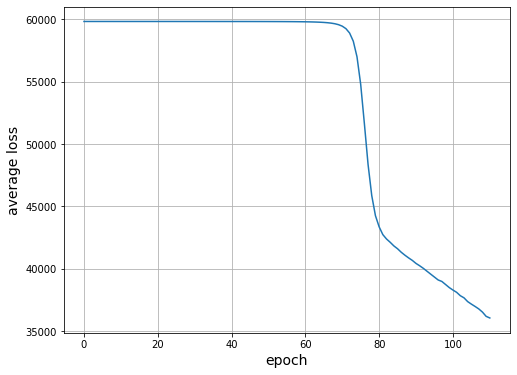

In [78]:
# plot the convergence of the estimated loss function
plt.figure(num=None,figsize=(8, 6))
plt.plot(loss_sequence,label="loss")
# Adding some bells and whistles to the plot
plt.grid(True, which="both")
plt.xlabel('epoch',fontsize=14)
plt.ylabel('average loss',fontsize=14)

Text(0, 0.5, 'validation RMSE')

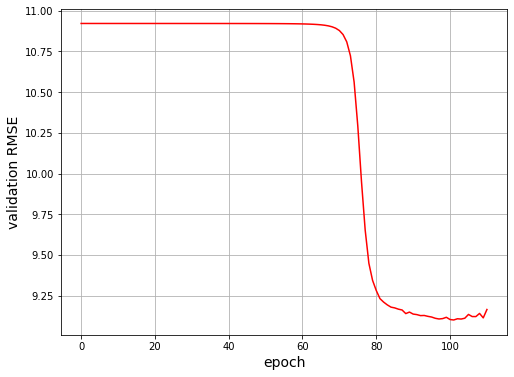

In [79]:
# plot the convergence of the validation RMSE
plt.figure(num=None,figsize=(8, 6))
plt.plot(validation_RMSE,c="red",label="validation RMSE")
# Adding some bells and whistles to the plot
plt.grid(True, which="both")
plt.xlabel('epoch',fontsize=14)
plt.ylabel('validation RMSE',fontsize=14)

In [80]:
net

Sequential(
  (0): Dense(90 -> 45, Activation(relu))
  (1): Dense(45 -> 45, Activation(relu))
  (2): Dense(45 -> 1, linear)
)

In [81]:
pre5=net(X_test_standard)
pre5=pre5.reshape(-1,)

In [82]:
#印出RMSE
RMSE5=RMSE(test_y_demean,pre5)
print(RMSE5)

9.255524


### MLP_2_dm_dropout

In [490]:
dropout1, dropout2 = 0.5 , 0.5

In [491]:
net = nn.Sequential()
net.add(nn.Dense(45, activation='relu'),
         # Add a dropout layer after the first fully connected layer
        nn.Dropout(dropout1),
        nn.Dense(45, activation='relu'),
        # Add a dropout layer after the second fully connected layer
        nn.Dropout(dropout2),
        nn.Dense(1))
net.initialize(init.Normal(sigma=0.01))

In [492]:
net.collect_params()

sequential52_ (
  Parameter dense153_weight (shape=(45, -1), dtype=float32)
  Parameter dense153_bias (shape=(45,), dtype=float32)
  Parameter dense154_weight (shape=(45, -1), dtype=float32)
  Parameter dense154_bias (shape=(45,), dtype=float32)
  Parameter dense155_weight (shape=(1, -1), dtype=float32)
  Parameter dense155_bias (shape=(1,), dtype=float32)
)

In [493]:
square_loss = gluon.loss.L2Loss()
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.0001})
num_examples = 10000

In [494]:
epochs = 3000
loss_sequence = []
num_batches = num_examples / batch_size
validation_RMSE=[]

In [495]:
for e in range(epochs):
    cumulative_loss = 0
    # inner loop
    for i, (data, label) in enumerate(train_data):
        data = data.as_in_context(model_ctx)
        label = label.as_in_context(model_ctx)
        with autograd.record():
            output = net(data)
            loss = square_loss(output, label)
        loss.backward()
        trainer.step(batch_size)
        cumulative_loss += np.mean(loss)
        
    pre=net(validation_x)
    pre=pre.reshape(-1,)
    v_RMSE=RMSE(validation_y_demean,pre)
    validation_RMSE.append(v_RMSE)
    print("Epoch %s, loss: %s,  validation RMSE: %s" % (e+1, cumulative_loss / num_examples,v_RMSE))
    loss_sequence.append(cumulative_loss)
    
    if len(validation_RMSE)>50:
        if ( float(validation_RMSE[-20]) - float(validation_RMSE[-1])) <=0.001:
            break #early stop

Epoch 1, loss: 5.9825068,  validation RMSE: 10.921441
Epoch 2, loss: 5.982495,  validation RMSE: 10.921435
Epoch 3, loss: 5.9824877,  validation RMSE: 10.92143
Epoch 4, loss: 5.9824843,  validation RMSE: 10.921425
Epoch 5, loss: 5.9824786,  validation RMSE: 10.921418
Epoch 6, loss: 5.982475,  validation RMSE: 10.921413
Epoch 7, loss: 5.982466,  validation RMSE: 10.921409
Epoch 8, loss: 5.9824677,  validation RMSE: 10.921404
Epoch 9, loss: 5.98246,  validation RMSE: 10.921398
Epoch 10, loss: 5.9824553,  validation RMSE: 10.921392
Epoch 11, loss: 5.9824576,  validation RMSE: 10.921388
Epoch 12, loss: 5.9824333,  validation RMSE: 10.921382
Epoch 13, loss: 5.982438,  validation RMSE: 10.921375
Epoch 14, loss: 5.982419,  validation RMSE: 10.921369
Epoch 15, loss: 5.9824295,  validation RMSE: 10.921362
Epoch 16, loss: 5.98242,  validation RMSE: 10.921354
Epoch 17, loss: 5.982399,  validation RMSE: 10.921347
Epoch 18, loss: 5.9824076,  validation RMSE: 10.921338
Epoch 19, loss: 5.9823895,  va

Text(0, 0.5, 'average loss')

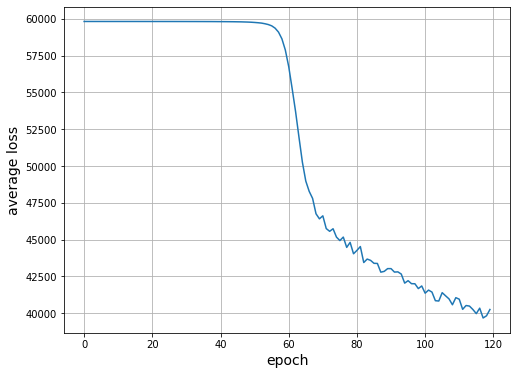

In [496]:
# plot the convergence of the estimated loss function
plt.figure(num=None,figsize=(8, 6))
plt.plot(loss_sequence,label="loss")
# Adding some bells and whistles to the plot
plt.grid(True, which="both")
plt.xlabel('epoch',fontsize=14)
plt.ylabel('average loss',fontsize=14)

Text(0, 0.5, 'validation RMSE')

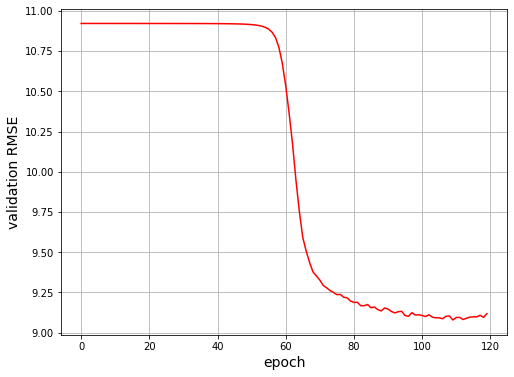

In [497]:
# plot the convergence of the validation RMSE
plt.figure(num=None,figsize=(8, 6))
plt.plot(validation_RMSE,c="red",label="validation RMSE")
# Adding some bells and whistles to the plot
plt.grid(True, which="both")
plt.xlabel('epoch',fontsize=14)
plt.ylabel('validation RMSE',fontsize=14)

In [498]:
net

Sequential(
  (0): Dense(90 -> 45, Activation(relu))
  (1): Dropout(p = 0.5, axes=())
  (2): Dense(45 -> 45, Activation(relu))
  (3): Dropout(p = 0.5, axes=())
  (4): Dense(45 -> 1, linear)
)

In [499]:
pre6=net(X_test_standard)
pre6=pre6.reshape(-1,)

In [500]:
#印出RMSE
RMSE6=RMSE(test_y_demean,pre6)
print(RMSE6)

9.197704


### MLP_2_ykeep

In [153]:
batch_size = 10
train_data2 = gluon.data.DataLoader(gluon.data.ArrayDataset(subtrain_x_10000, subtrain_y_10000),
                                      batch_size=batch_size, shuffle=True)

In [154]:
net = nn.Sequential()
net.add(nn.Dense(45, activation='relu'),nn.Dense(45, activation='relu'),
        nn.Dense(1))
net.initialize(init.Normal(sigma=0.001))

In [155]:
net.collect_params()

sequential12_ (
  Parameter dense33_weight (shape=(45, -1), dtype=float32)
  Parameter dense33_bias (shape=(45,), dtype=float32)
  Parameter dense34_weight (shape=(45, -1), dtype=float32)
  Parameter dense34_bias (shape=(45,), dtype=float32)
  Parameter dense35_weight (shape=(1, -1), dtype=float32)
  Parameter dense35_bias (shape=(1,), dtype=float32)
)

In [156]:
square_loss = gluon.loss.L2Loss()
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.0001})
num_examples = 10000

In [157]:
epochs = 3000
loss_sequence = []
num_batches = num_examples / batch_size
validation_RMSE=[]

In [158]:
for e in range(epochs):
    cumulative_loss = 0
    # inner loop
    for i, (data, label) in enumerate(train_data2):
        data = data.as_in_context(model_ctx)
        label = label.as_in_context(model_ctx)
        with autograd.record():
            output = net(data)
            loss = square_loss(output, label)
        loss.backward()
        trainer.step(batch_size)
        cumulative_loss += np.mean(loss)
        
    pre=net(validation_x)
    pre=pre.reshape(-1,)
    v_RMSE=RMSE(validation_y,pre)
    validation_RMSE.append(v_RMSE)
    print("Epoch %s, loss: %s,  validation RMSE: %s" % (e+1, cumulative_loss / num_examples,v_RMSE))
    loss_sequence.append(cumulative_loss)
    
    if len(validation_RMSE)>100:
        if ( float(validation_RMSE[-40]) - float(validation_RMSE[-1])) <=0.001:
            if ( float(validation_RMSE[-37]) - float(validation_RMSE[-3])) <=0.001:
                break #early stop

Epoch 1, loss: 524157440.0,  validation RMSE: 1553.2446
Epoch 2, loss: 116172.69,  validation RMSE: 1464.1932
Epoch 3, loss: 103233.22,  validation RMSE: 1380.2505
Epoch 4, loss: 91735.24,  validation RMSE: 1301.1218
Epoch 5, loss: 81518.11,  validation RMSE: 1226.5334
Epoch 6, loss: 72439.164,  validation RMSE: 1156.2196
Epoch 7, loss: 64371.52,  validation RMSE: 1089.9406
Epoch 8, loss: 57202.664,  validation RMSE: 1027.4626
Epoch 9, loss: 50832.375,  validation RMSE: 968.5692
Epoch 10, loss: 45171.652,  validation RMSE: 913.05316
Epoch 11, loss: 40141.6,  validation RMSE: 860.72217
Epoch 12, loss: 35671.797,  validation RMSE: 811.3939
Epoch 13, loss: 31699.836,  validation RMSE: 764.8955
Epoch 14, loss: 28170.402,  validation RMSE: 721.06
Epoch 15, loss: 25034.01,  validation RMSE: 679.7408
Epoch 16, loss: 22246.973,  validation RMSE: 640.7927
Epoch 17, loss: 19770.38,  validation RMSE: 604.0795
Epoch 18, loss: 17569.686,  validation RMSE: 569.4731
Epoch 19, loss: 15614.095,  valida

Epoch 152, loss: 5.984184,  validation RMSE: 10.921666
Epoch 153, loss: 5.9840546,  validation RMSE: 10.920727
Epoch 154, loss: 5.9835625,  validation RMSE: 10.920311
Epoch 155, loss: 5.9832478,  validation RMSE: 10.920241
Epoch 156, loss: 5.9830246,  validation RMSE: 10.919613
Epoch 157, loss: 5.982957,  validation RMSE: 10.919514
Epoch 158, loss: 5.9825745,  validation RMSE: 10.920088
Epoch 159, loss: 5.981745,  validation RMSE: 10.91891
Epoch 160, loss: 5.9822183,  validation RMSE: 10.92007
Epoch 161, loss: 5.982272,  validation RMSE: 10.91866
Epoch 162, loss: 5.9821925,  validation RMSE: 10.919172
Epoch 163, loss: 5.9821076,  validation RMSE: 10.918606
Epoch 164, loss: 5.9803863,  validation RMSE: 10.920627
Epoch 165, loss: 5.9818926,  validation RMSE: 10.918085
Epoch 166, loss: 5.980903,  validation RMSE: 10.919383
Epoch 167, loss: 5.981748,  validation RMSE: 10.917894
Epoch 168, loss: 5.981909,  validation RMSE: 10.91819
Epoch 169, loss: 5.9817653,  validation RMSE: 10.91791
Epoc

Text(0, 0.5, 'average loss')

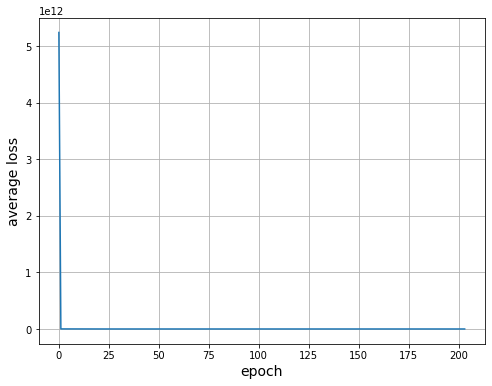

In [159]:
# plot the convergence of the estimated loss function
plt.figure(num=None,figsize=(8, 6))
plt.plot(loss_sequence,label="loss")
# Adding some bells and whistles to the plot
plt.grid(True, which="both")
plt.xlabel('epoch',fontsize=14)
plt.ylabel('average loss',fontsize=14)

Text(0, 0.5, 'validation RMSE')

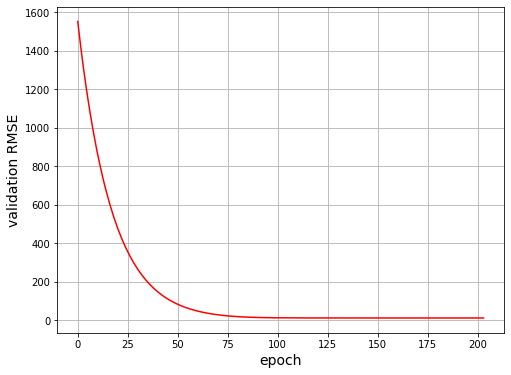

In [160]:
# plot the convergence of the validation RMSE
plt.figure(num=None,figsize=(8, 6))
plt.plot(validation_RMSE,c="red",label="validation RMSE")
# Adding some bells and whistles to the plot
plt.grid(True, which="both")
plt.xlabel('epoch',fontsize=14)
plt.ylabel('validation RMSE',fontsize=14)

In [161]:
net

Sequential(
  (0): Dense(90 -> 45, Activation(relu))
  (1): Dense(45 -> 45, Activation(relu))
  (2): Dense(45 -> 1, linear)
)

In [162]:
pre7=net(X_test_standard)
pre7=pre7.reshape(-1,)

In [163]:
pre7.shape

(51630,)

In [164]:
Y_test.shape

(51630,)

In [165]:
#印出RMSE
RMSE7=RMSE(Y_test,pre7)
print(RMSE7)

10.852086


### MLP_2_ykeep_L2

In [319]:
batch_size = 10
train_data2 = gluon.data.DataLoader(gluon.data.ArrayDataset(subtrain_x_10000, subtrain_y_10000),
                                      batch_size=batch_size, shuffle=True)

In [320]:
net = nn.Sequential()
net.add(nn.Dense(45, activation='relu'),
        nn.Dense(45, activation='relu'),
        nn.Dense(1))
net.initialize(init.Normal(sigma=0.001))

In [321]:
net.collect_params()

sequential33_ (
  Parameter dense96_weight (shape=(45, -1), dtype=float32)
  Parameter dense96_bias (shape=(45,), dtype=float32)
  Parameter dense97_weight (shape=(45, -1), dtype=float32)
  Parameter dense97_bias (shape=(45,), dtype=float32)
  Parameter dense98_weight (shape=(1, -1), dtype=float32)
  Parameter dense98_bias (shape=(1,), dtype=float32)
)

In [322]:
wd=0.03

In [323]:
square_loss = gluon.loss.L2Loss()
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.0001,'wd': wd})
num_examples = 10000

In [324]:
# The bias parameter has not decayed. Bias names generally end with "bias"
net.collect_params('.*bias').setattr('wd_mult', 0)

In [325]:
epochs = 3000
loss_sequence = []
num_batches = num_examples / batch_size
validation_RMSE=[]

In [326]:
for e in range(epochs):
    cumulative_loss = 0
    # inner loop
    for i, (data, label) in enumerate(train_data2):
        data = data.as_in_context(model_ctx)
        label = label.as_in_context(model_ctx)
        with autograd.record():
            output = net(data)
            loss = square_loss(output, label)
        loss.backward()
        trainer.step(batch_size)
        cumulative_loss += np.mean(loss)
        
    pre=net(validation_x)
    pre=pre.reshape(-1,)
    v_RMSE=RMSE(validation_y,pre)
    validation_RMSE.append(v_RMSE)
    print("Epoch %s, loss: %s,  validation RMSE: %s" % (e+1, cumulative_loss / num_examples,v_RMSE))
    loss_sequence.append(cumulative_loss)
    
    if len(validation_RMSE)>100:
        if ( float(validation_RMSE[-40]) - float(validation_RMSE[-1])) <=0.001:
            if ( float(validation_RMSE[-37]) - float(validation_RMSE[-3])) <=0.001:
                break #early stop

Epoch 1, loss: 4568685.0,  validation RMSE: 1822.934
Epoch 2, loss: 150608.75,  validation RMSE: 1649.457
Epoch 3, loss: 123308.016,  validation RMSE: 1492.4902
Epoch 4, loss: 100956.19,  validation RMSE: 1350.462
Epoch 5, loss: 82656.24,  validation RMSE: 1221.9514
Epoch 6, loss: 67673.59,  validation RMSE: 1105.6716
Epoch 7, loss: 55407.035,  validation RMSE: 1000.4577
Epoch 8, loss: 45364.0,  validation RMSE: 905.25964
Epoch 9, loss: 37141.754,  validation RMSE: 819.1235
Epoch 10, loss: 30409.945,  validation RMSE: 741.18414
Epoch 11, loss: 24898.35,  validation RMSE: 670.6623
Epoch 12, loss: 20385.924,  validation RMSE: 606.85626
Epoch 13, loss: 16691.562,  validation RMSE: 549.12305
Epoch 14, loss: 13666.864,  validation RMSE: 496.88763
Epoch 15, loss: 11190.556,  validation RMSE: 449.6246
Epoch 16, loss: 9163.067,  validation RMSE: 406.86328
Epoch 17, loss: 7503.118,  validation RMSE: 368.17157
Epoch 18, loss: 6144.03,  validation RMSE: 333.1648
Epoch 19, loss: 5031.3154,  valida

Text(0, 0.5, 'average loss')

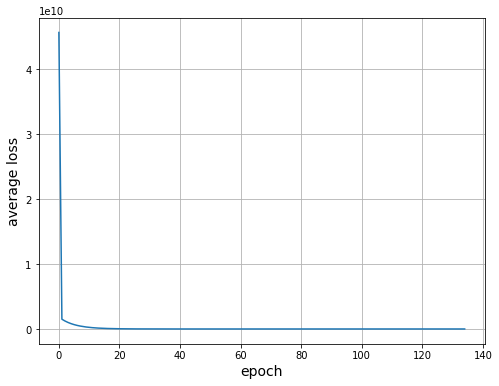

In [327]:
# plot the convergence of the estimated loss function
plt.figure(num=None,figsize=(8, 6))
plt.plot(loss_sequence,label="loss")
# Adding some bells and whistles to the plot
plt.grid(True, which="both")
plt.xlabel('epoch',fontsize=14)
plt.ylabel('average loss',fontsize=14)

Text(0, 0.5, 'validation RMSE')

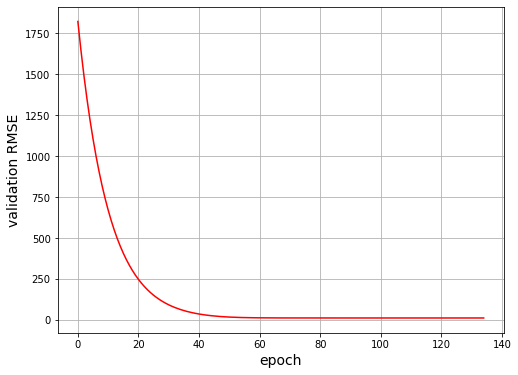

In [328]:
# plot the convergence of the validation RMSE
plt.figure(num=None,figsize=(8, 6))
plt.plot(validation_RMSE,c="red",label="validation RMSE")
# Adding some bells and whistles to the plot
plt.grid(True, which="both")
plt.xlabel('epoch',fontsize=14)
plt.ylabel('validation RMSE',fontsize=14)

In [329]:
net

Sequential(
  (0): Dense(90 -> 45, Activation(relu))
  (1): Dense(45 -> 45, Activation(relu))
  (2): Dense(45 -> 1, linear)
)

In [330]:
pre8=net(X_test_standard)
pre8=pre8.reshape(-1,)

In [331]:
#印出RMSE
RMSE8=RMSE(Y_test,pre8)
print(RMSE8)

10.85267


### MLP_2_ykeep_dropout	

In [575]:
batch_size = 10
train_data2 = gluon.data.DataLoader(gluon.data.ArrayDataset(subtrain_x_10000, subtrain_y_10000),
                                      batch_size=batch_size, shuffle=True)

In [576]:
dropout1, dropout2 = 0.5 , 0.5

In [577]:
net = nn.Sequential()
net.add(nn.Dense(45, activation='relu'),
         # Add a dropout layer after the first fully connected layer
        nn.Dropout(dropout1),
        nn.Dense(45, activation='relu'),
        # Add a dropout layer after the second fully connected layer
        nn.Dropout(dropout2),
        nn.Dense(1))

In [578]:
net.initialize(init.Normal(sigma=0.001))

In [579]:
net.collect_params()

sequential62_ (
  Parameter dense183_weight (shape=(45, -1), dtype=float32)
  Parameter dense183_bias (shape=(45,), dtype=float32)
  Parameter dense184_weight (shape=(45, -1), dtype=float32)
  Parameter dense184_bias (shape=(45,), dtype=float32)
  Parameter dense185_weight (shape=(1, -1), dtype=float32)
  Parameter dense185_bias (shape=(1,), dtype=float32)
)

In [580]:
square_loss = gluon.loss.L2Loss()
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.000001})
num_examples = 10000

In [581]:
epochs = 3000
loss_sequence = []
num_batches = num_examples / batch_size
validation_RMSE=[]

In [582]:
for e in range(epochs):
    cumulative_loss = 0
    # inner loop
    for i, (data, label) in enumerate(train_data2):
        data = data.as_in_context(model_ctx)
        label = label.as_in_context(model_ctx)
        with autograd.record():
            output = net(data)
            loss = square_loss(output, label)
        loss.backward()
        trainer.step(batch_size)
        cumulative_loss += np.mean(loss)
        
    pre=net(validation_x)
    pre=pre.reshape(-1,)
    v_RMSE=RMSE(validation_y,pre)
    validation_RMSE.append(v_RMSE)
    print("Epoch %s, loss: %s,  validation RMSE: %s" % (e+1, cumulative_loss / num_examples,v_RMSE))
    loss_sequence.append(cumulative_loss)
    
    if len(validation_RMSE)>100:
        if ( float(validation_RMSE[-40]) - float(validation_RMSE[-1])) <=0.001:
            if ( float(validation_RMSE[-37]) - float(validation_RMSE[-3])) <=0.001:
                break #early stop

Epoch 1, loss: 199480.69,  validation RMSE: 1996.3987
Epoch 2, loss: 199081.44,  validation RMSE: 1994.3898
Epoch 3, loss: 198647.83,  validation RMSE: 1991.664
Epoch 4, loss: 182157.97,  validation RMSE: 823.1388
Epoch 5, loss: 27277.92,  validation RMSE: 260.59274
Epoch 6, loss: 17052.932,  validation RMSE: 216.57951
Epoch 7, loss: 14512.474,  validation RMSE: 193.401
Epoch 8, loss: 14703.401,  validation RMSE: 171.61671
Epoch 9, loss: 12305.237,  validation RMSE: 177.24324
Epoch 10, loss: 11253.699,  validation RMSE: 150.52039
Epoch 11, loss: 11908.033,  validation RMSE: 154.68468
Epoch 12, loss: 10280.371,  validation RMSE: 145.56956
Epoch 13, loss: 10325.203,  validation RMSE: 130.66933
Epoch 14, loss: 9505.181,  validation RMSE: 147.72528
Epoch 15, loss: 9547.106,  validation RMSE: 93.84193
Epoch 16, loss: 9435.206,  validation RMSE: 115.47801
Epoch 17, loss: 8969.498,  validation RMSE: 112.375084
Epoch 18, loss: 9182.673,  validation RMSE: 78.33377
Epoch 19, loss: 8986.698,  val

Text(0, 0.5, 'average loss')

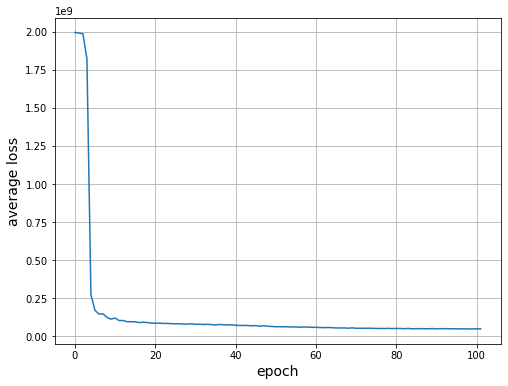

In [583]:
# plot the convergence of the estimated loss function
plt.figure(num=None,figsize=(8, 6))
plt.plot(loss_sequence,label="loss")
# Adding some bells and whistles to the plot
plt.grid(True, which="both")
plt.xlabel('epoch',fontsize=14)
plt.ylabel('average loss',fontsize=14)

Text(0, 0.5, 'validation RMSE')

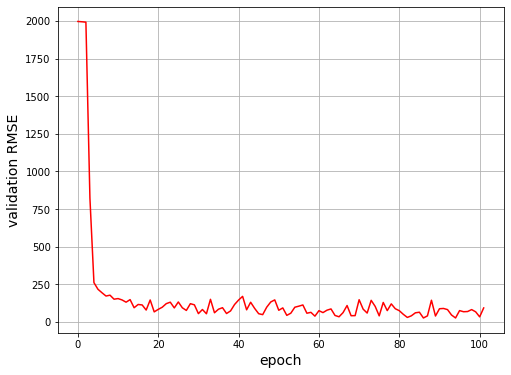

In [584]:
# plot the convergence of the validation RMSE
plt.figure(num=None,figsize=(8, 6))
plt.plot(validation_RMSE,c="red",label="validation RMSE")
# Adding some bells and whistles to the plot
plt.grid(True, which="both")
plt.xlabel('epoch',fontsize=14)
plt.ylabel('validation RMSE',fontsize=14)

In [585]:
net

Sequential(
  (0): Dense(90 -> 45, Activation(relu))
  (1): Dropout(p = 0.5, axes=())
  (2): Dense(45 -> 45, Activation(relu))
  (3): Dropout(p = 0.5, axes=())
  (4): Dense(45 -> 1, linear)
)

In [586]:
pre9=net(X_test_standard)
pre9=pre9.reshape(-1,)

In [587]:
pre9

array([1907.7885, 1898.3359, 1921.6045, ..., 1914.984 , 1897.6555,
       1887.128 ])

In [588]:
#印出RMSE
RMSE9=RMSE(Y_test,pre9)
print(RMSE9)

92.87263


### MLP_2_dm_dropout_full

In [613]:
batch_size = 100
train_data3 = gluon.data.DataLoader(gluon.data.ArrayDataset(subtrain_x, subtrain_y_demean),
                                      batch_size=batch_size, shuffle=True)

In [614]:
dropout1, dropout2 = 0.5 , 0.5

In [615]:
net = nn.Sequential()
net.add(nn.Dense(45, activation='relu'),
         # Add a dropout layer after the first fully connected layer
        nn.Dropout(dropout1),
        nn.Dense(45, activation='relu'),
        # Add a dropout layer after the second fully connected layer
        nn.Dropout(dropout2),
        nn.Dense(1))

In [616]:
net.initialize(init.Normal(sigma=0.01))

In [617]:
net.collect_params()

sequential66_ (
  Parameter dense195_weight (shape=(45, -1), dtype=float32)
  Parameter dense195_bias (shape=(45,), dtype=float32)
  Parameter dense196_weight (shape=(45, -1), dtype=float32)
  Parameter dense196_bias (shape=(45,), dtype=float32)
  Parameter dense197_weight (shape=(1, -1), dtype=float32)
  Parameter dense197_bias (shape=(1,), dtype=float32)
)

In [631]:
square_loss = gluon.loss.L2Loss()
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.0001})
num_examples = len(subtrain_x)

In [619]:
epochs = 50
loss_sequence = []
num_batches = num_examples / batch_size
validation_RMSE=[]

In [620]:
for e in range(epochs):
    cumulative_loss = 0
    # inner loop
    for i, (data, label) in enumerate(train_data3):
        data = data.as_in_context(model_ctx)
        label = label.as_in_context(model_ctx)
        with autograd.record():
            output = net(data)
            loss = square_loss(output, label)
        loss.backward()
        trainer.step(batch_size)
        cumulative_loss += np.mean(loss)
        
    pre=net(validation_x)
    pre=pre.reshape(-1,)
    v_RMSE=RMSE(validation_y_demean,pre)
    validation_RMSE.append(v_RMSE)
    print("Epoch %s, loss: %s,  validation RMSE: %s" % (e+1, cumulative_loss / num_examples,v_RMSE))
    loss_sequence.append(cumulative_loss)


Epoch 1, loss: 0.5987284,  validation RMSE: 10.920958
Epoch 2, loss: 0.5507234,  validation RMSE: 9.213392
Epoch 3, loss: 0.44042802,  validation RMSE: 9.003743
Epoch 4, loss: 0.42728764,  validation RMSE: 8.891505
Epoch 5, loss: 0.42099416,  validation RMSE: 8.849994
Epoch 6, loss: 0.41856828,  validation RMSE: 8.844035
Epoch 7, loss: 0.41556713,  validation RMSE: 8.794021
Epoch 8, loss: 0.41424128,  validation RMSE: 8.794624
Epoch 9, loss: 0.41319162,  validation RMSE: 8.814263
Epoch 10, loss: 0.41149595,  validation RMSE: 8.773685
Epoch 11, loss: 0.41129714,  validation RMSE: 8.773925
Epoch 12, loss: 0.41112253,  validation RMSE: 8.756505
Epoch 13, loss: 0.41019598,  validation RMSE: 8.780356
Epoch 14, loss: 0.409926,  validation RMSE: 8.745885
Epoch 15, loss: 0.40932834,  validation RMSE: 8.759244
Epoch 16, loss: 0.40882304,  validation RMSE: 8.732048
Epoch 17, loss: 0.4085674,  validation RMSE: 8.745572
Epoch 18, loss: 0.40858215,  validation RMSE: 8.749394
Epoch 19, loss: 0.40825

Text(0, 0.5, 'average loss')

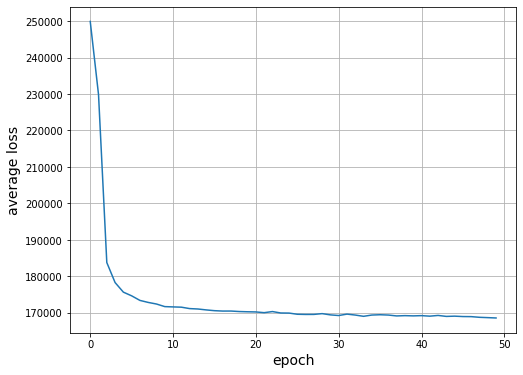

In [621]:
# plot the convergence of the estimated loss function
plt.figure(num=None,figsize=(8, 6))
plt.plot(loss_sequence,label="loss")
# Adding some bells and whistles to the plot
plt.grid(True, which="both")
plt.xlabel('epoch',fontsize=14)
plt.ylabel('average loss',fontsize=14)

Text(0, 0.5, 'validation RMSE')

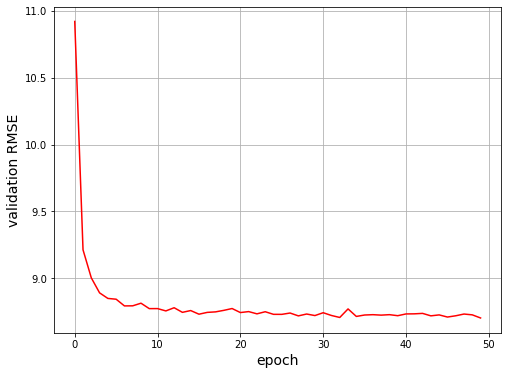

In [622]:
# plot the convergence of the validation RMSE
plt.figure(num=None,figsize=(8, 6))
plt.plot(validation_RMSE,c="red",label="validation RMSE")
# Adding some bells and whistles to the plot
plt.grid(True, which="both")
plt.xlabel('epoch',fontsize=14)
plt.ylabel('validation RMSE',fontsize=14)

In [623]:
net

Sequential(
  (0): Dense(90 -> 45, Activation(relu))
  (1): Dropout(p = 0.5, axes=())
  (2): Dense(45 -> 45, Activation(relu))
  (3): Dropout(p = 0.5, axes=())
  (4): Dense(45 -> 1, linear)
)

In [624]:
pre10=net(X_test_standard)
pre10=pre10.reshape(-1,)

In [625]:
#印出RMSE
RMSE10=RMSE(test_y_demean,pre10)
print(RMSE10)

8.858317


## Q2

In [626]:
case=['OLS','MLP_0_dm','MLP_1_dm','MLP_2_dm','MLP_2_dm_L2','MLP_2_dm_dropout'
      ,'MLP_2_ykeep','MLP_2_ykeep_L2','MLP_2_ykeep_dropout','MLP_2_dm_dropout_full']

In [628]:
RMSE_value=[RMSE1,RMSE2,RMSE3,RMSE4,RMSE5,RMSE6,RMSE7,RMSE8,RMSE9,RMSE10]

In [630]:
df_summary=pd.DataFrame({'case':case,'RSME':RMSE_value})
df_summary

,case,RSME
0,OLS,9.550725
1,MLP_0_dm,9.549119
2,MLP_1_dm,9.242959
3,MLP_2_dm,9.216016
4,MLP_2_dm_L2,9.255524
5,MLP_2_dm_dropout,9.197704
6,MLP_2_ykeep,10.852086
7,MLP_2_ykeep_L2,10.85267
8,MLP_2_ykeep_dropout,92.87263
9,MLP_2_dm_dropout_full,8.858317


從最後的結果可以看到最好的RSME為：Case10:MLP_2_dm_dropout_full	的 8.858317

並且可以發現：

1.demean_y 的效果會比keep_y 來得更好，而且 keep_y 使用dropout時 模型表現不穩定。

2.加上兩層hidden layer 會比一層hidden layer表現來得好，而一層hidden layer也會比無hidden layer表現來得好。

3.demean_y後，並加上兩層hidden layer再搭配dropout的模型 在只有10000筆資料時，效果最好。

4.在找出適用的模型後，再將training data數量增加，一樣有效大幅下降test 的RMSE。

從這次作業也可以總結當我們訓練深度學習模型時，我們應該要注意validation data才不會有overfitting的情形發生，至於要不要demean的話，可能要再視模型使用，至少這次迴歸的模型中demean效果是很顯著的。

最後調整完模型後，並將訓練資料筆數增加，並放入調整好的模型，如此就能使用最恰當的模型進行預測，也不會有過適的問題。

我期末專案當時就是沒有考量到這個點，所以當時把訓練模型訓練得太好，反而預測效果不佳，尤其在深度學習的模型中要特別注意。